In [28]:
import numpy as np
import script
import pylab as plt
import nibabel as nib
import os
from skimage import filters
import scipy.ndimage as ndi
from scipy.ndimage.morphology import binary_erosion as be
from scipy.ndimage.morphology import binary_fill_holes as bfh
from scipy.ndimage.morphology import binary_dilation as bd
from scipy.ndimage.morphology import binary_opening as bo
from scipy.ndimage.morphology import binary_closing as bc
from scipy.ndimage.morphology import grey_dilation as gd
import BET
import morphsnakes.morphsnakes as morphsnakes
import time

In [2]:
planes = np.load('planes.npy')

samps = ['Sample-1', 'Sample-2', 'Sample-3', 'Sample-4', 'Sample-5', 'Sample-A',
 'Sample-B', 'Sample-C', 'Sample-D', 'Sample-F', 'Sample-G', 'Sample-H',
 'Sample-I']

reshaped_niftis = []
for i in range(len(samps)):
    reshaped_niftis.append(os.path.join('/Users/Sinead/DC-project/Post-unskewed-reshaped/', 
                                        '{}.nii.gz'.format(samps[i])))

In [3]:
i = 5
path = reshaped_niftis[i]
samp = samps[i]

In [4]:
img = nib.load(path)
array = img.get_data()

In [256]:
def pad(mask):
    mask = mask.astype(int)
    from skimage.segmentation import find_boundaries as boundaries
    bounds = boundaries(mask, connectivity=0, mode='outer', background=1)
    return ((bounds.astype(int)+mask)>0).astype(int)

In [412]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4446187/figure/F1/
# reference FSL BET
thresholded = BET.threshold(array,low=0, high=60)
# erodedx3 = be(be(be(thresholded)))
# paddedx3 = pad(pad(pad(erodedx3)))

In [331]:
grad = abs(np.gradient(array)[0])
bounds = boundaries(thresholded>0, connectivity=0, mode='outer', background=0)

mask = (np.multiply(grad>10, grad<25)).astype(int)
grad = np.multiply(mask, grad)

combine = (mask+bounds)>0
bounds = boundaries(combine, connectivity=0, mode='outer', background=0)

<IPython.core.display.Javascript object>


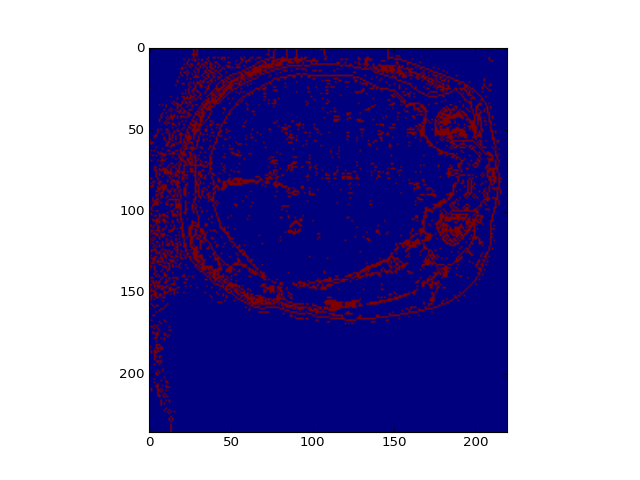

In [361]:
%matplotlib nbagg
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(combine[:,:,80])
plt.ion()

In [362]:
primed = np.multiply((combine==False).astype(int), thresholded)

In [353]:
# spaced=BET.spacer(BET.spacer(BET.spacer(thresholded)))

In [363]:
# data = BET.extract(np.multiply(erodedx3.astype(int), array), samp)
data = bfh(BET.extract(primed, samp))

<IPython.core.display.Javascript object>


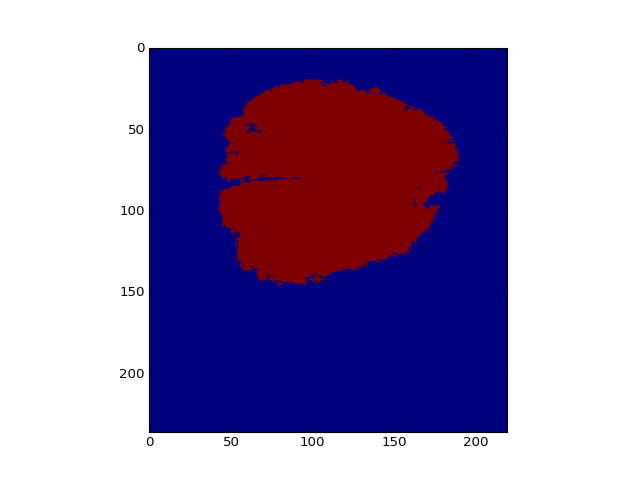

In [396]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4446187/figure/F1/
# reference FSL BET
plt.ion()
%matplotlib nbagg
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(bfh(data)[:,:,110])
plt.ion()

In [413]:
mask = data>0
mask = mask.astype(float)

In [414]:
macwe = morphsnakes.MorphACWE(mask, smoothing=2, lambda1=1, lambda2=2)
macwe.levelset = mask
macwe.balloon = 1
t0 = time.time()
macwe.run(1)
t1 = time.time()
print t1-t0

outline = macwe.levelset

17.0421030521


In [415]:
# macwe.step()
# outline = macwe.levelset
result = np.multiply(outline, array)
logical = np.multiply(result<100, result>0)
result = np.multiply(logical.astype(int), array)

In [374]:
# paddedx3 = pad(pad(pad(result)))
# brain0 = np.multiply(paddedx3,array)
# logical = np.multiply(brain0<100, brain0>0)
# brain = np.multiply(logical.astype(int), array)

<IPython.core.display.Javascript object>


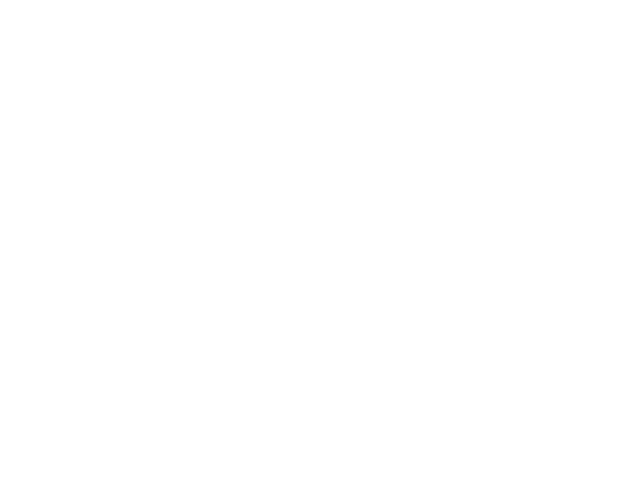

In [417]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4446187/figure/F1/
# reference FSL BET
plt.ion()
%matplotlib nbagg
fig = plt.figure()
ax = fig.add_subplot(111)
thresholded = np.multiply(thresholded, np.multiply(thresholded>0, thresholded<100).astype(int))
ax.imshow(result[:,:,110])
plt.ion()

In [149]:
def spacer(data):
    grad = abs(np.gradient(data)[0])
    mask1 = grad<8
    mask2 = grad>0
    mask3 = np.multiply(mask1,mask2) 
    mask4 = (mask3.astype(int)+bounds.astype(int))>0
    result = np.multiply(data, mask4)
    return result

In [131]:
from skimage.segmentation import find_boundaries as boundaries
bounds = boundaries(mask, connectivity=1, mode='inner', background=0)
bounds = bounds==False
bounds = pad(bounds)

<IPython.core.display.Javascript object>


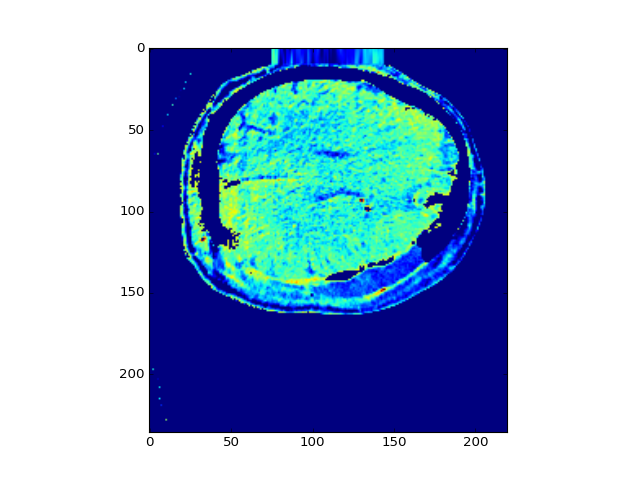

In [419]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(thresholded[:,:,110])
plt.ion()

In [ ]:
# do gradient thing. If the pixel is on an edge, don't delete. use find boundaries?

In [ ]:
# up to here
## see if morphsnakes can be used directly on data

In [12]:
mask = data>0
mask = mask.astype(float)

In [66]:
macwe = morphsnakes.MorphACWE(mask, smoothing=1, lambda1=1, lambda2=1)
macwe.levelset = mask
t0 = time.time()
macwe.step()
t1 = time.time()
print t1-t0

outline = macwe.levelset

11.8952350616


In [67]:
macwe.step()

<IPython.core.display.Javascript object>


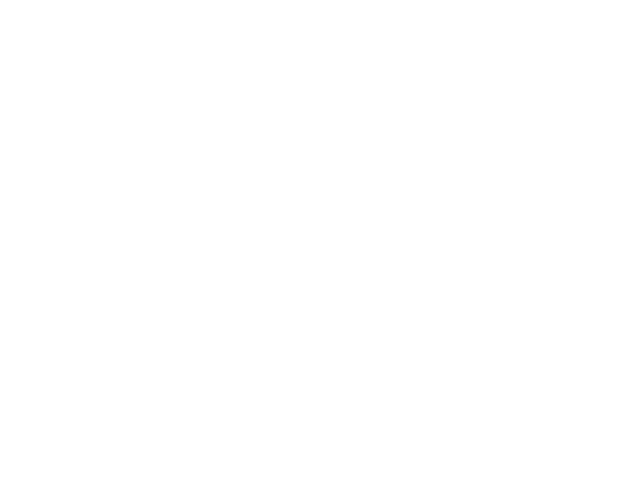

In [68]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(outline[:,:,80])
plt.ion()

In [64]:
# g(I)
gI = morphsnakes.gborders(data, alpha=1000, sigma=20)

# Morphological GAC. Initialization of the level-set.
mgac = morphsnakes.MorphGAC(gI, smoothing=1, threshold=0.5, balloon=1)
mgac.levelset = mask
mgac.step()
outline = mgac.levelset

In [ ]:
macwe = morphsnakes.MorphACWE(mask, smoothing=40, lambda1=1, lambda2=2)
macwe.levelset = mask.astype(float)
t0 = time.time()
macwe.step()
t1 = time.time()
print t1-t0

outline = macwe.levelset

In [11]:
spaced = BET.spacer(data)
spaced2 = BET.spacer(spaced)

In [12]:
spaced3 = BET.spacer(spaced2)

<IPython.core.display.Javascript object>


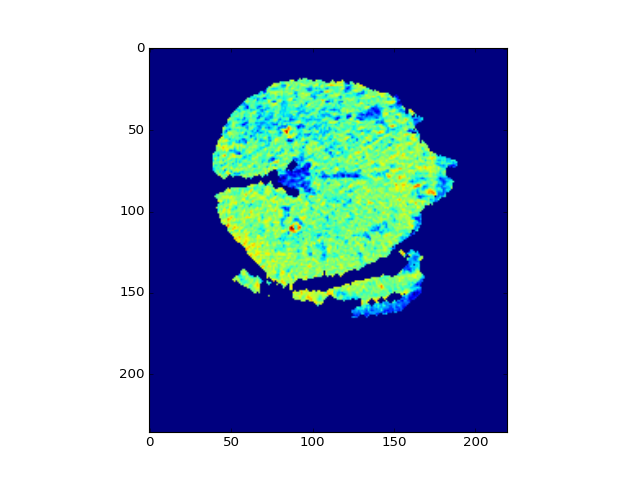

In [187]:
%matplotlib nbagg
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(spaced2[:,:,80])
plt.ion()

In [15]:
data2 = BET.extract(spaced2, samp)
data3 = BET.extract(spaced3, samp)

<IPython.core.display.Javascript object>


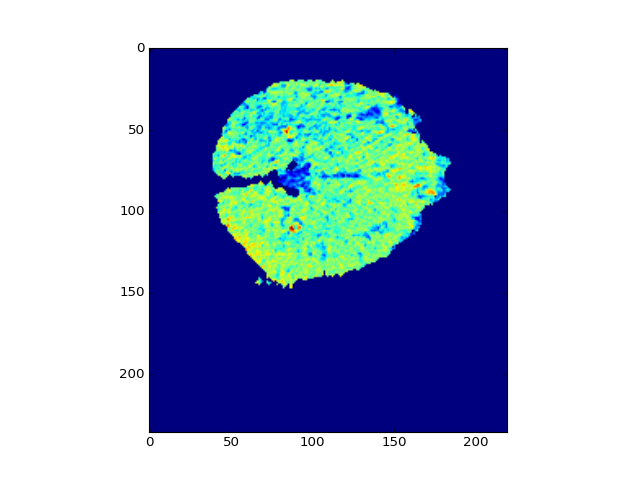

In [188]:
%matplotlib nbagg
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(data2[:,:,80])
plt.ion()

<IPython.core.display.Javascript object>


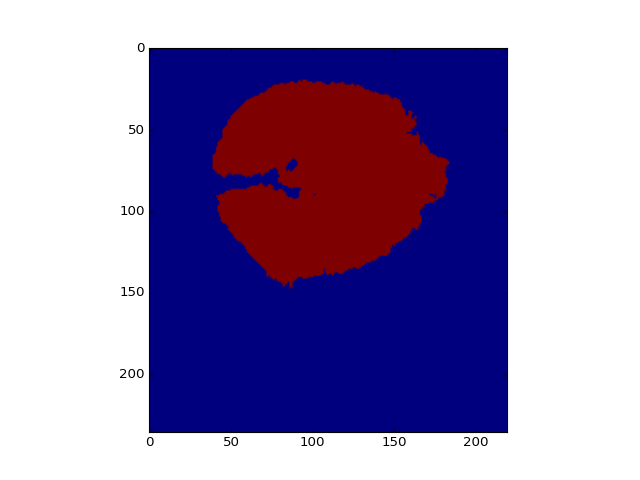

In [189]:
mask = data3>0
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(mask[:,:,80])
plt.ion()

In [173]:
from skimage.segmentation import find_boundaries as boundaries
bounds = boundaries(mask, connectivity=1, mode='outer', background=0)
mask = mask.astype(int)+bounds.astype(int)

In [174]:
import time

In [175]:
import morphsnakes.morphsnakes as morphsnakes

In [78]:
macwe = morphsnakes.MorphACWE(mask, smoothing=40, lambda1=1, lambda2=2)
macwe.levelset = mask.astype(float)
t0 = time.time()
macwe.step()
t1 = time.time()
print t1-t0

outline = macwe.levelset

179.103720903


In [216]:
print outline.shape
def pad(mask):
    mask = mask.astype(int)
    from skimage.segmentation import find_boundaries as boundaries
    bounds = boundaries(mask, connectivity=1, mode='outer', background=0)
    mask = mask+bounds.astype(int)
    return mask

(236, 220, 183)


In [217]:
for i in range(5):
    outline = pad(outline)
outline = outline>0
outline = outline.astype(int)

In [218]:
brain = np.multiply(outline, array)

In [219]:
thr = BET.threshold(brain, low=-200, high=1100)

<IPython.core.display.Javascript object>


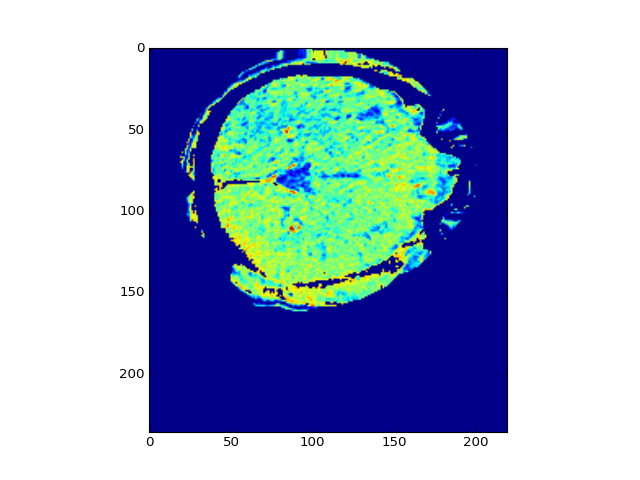

In [214]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(thr[:,:,80]) # with 50
plt.ion()